# LPPUFv1 Bit Sensitivity

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import pypuf.attack
import pypuf.batch
import pypuf.metrics
from lppuf import LPPUFv1

sns.set_style('whitegrid')

In [2]:
import logging

logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.ERROR)

In [3]:
%%bash
#rm -rf results/v1/bit-sensitivity
mkdir -p results/v1/bit-sensitivity

In [4]:
results = pypuf.batch.FilesystemResultCollection('results/v1/bit-sensitivity')

In [5]:
class LPPUFv1BitSensitivityAnalysis(pypuf.batch.StudyBase):
    
    def parameter_matrix(self):
        return [
            dict(
                n=n,
                seed=seed,
                m=m,
                puf_type=puf_type,
                N=10000,
            )
            for n in [64]
            for seed in range(10)
            for m in [1, 2, 4, 8, 16]
            for puf_type in ['LP-PUF', 'XOR Arbiter PUF']
        ]

    @staticmethod
    def flip_bit(challenges, i):
        flipped_challenges = challenges.copy()
        flipped_challenges[:, i] *= -1
        return flipped_challenges

    def run(self, n, seed, m, puf_type, N=1000):
        # create PUF simulation instance
        if puf_type == 'LP-PUF':
            puf = LPPUFv1(
                n=n, m=m, seed=pypuf.simulation.base.Simulation.seed(f"LP-PUF Bit Sensitivity Experiment Seed {seed}"),
            )
        elif puf_type == 'XOR Arbiter PUF':
            puf = pypuf.simulation.XORArbiterPUF(
                n=n, k=m, seed=pypuf.simulation.base.Simulation.seed(f"LP-PUF Bit Sensitivity Experiment Seed {seed}"),
            )
        else:
            raise ValueError(f"Unknown PUF type {puf_type}")
        
        # generate overall CRPs
        crps = pypuf.io.ChallengeResponseSet.from_simulation(puf, N=N, seed=1)        

        # evaluate sensitivity of each bit individually
        bit_sensitivity = [np.mean(crps.responses.squeeze() == puf.eval(self.flip_bit(crps.challenges, i))) for i in range(n)]
        
        # measure success
        return {
            'bit_sensitivity': bit_sensitivity,
        } 

In [6]:
study = LPPUFv1BitSensitivityAnalysis(results)

In [7]:
study.run_all()

DEBUG:root:LPPUFv1BitSensitivityAnalysis: running 0 unfinished jobs from a batch of 100 (100 of this batch already completed, batch total 100, study total 100 jobs)


In [8]:
data = pd.DataFrame(study.results.load_all())

wide_data = data.copy()
for i in range(64):
    wide_data[f'bit_sensitivity_{i}'] = data.apply(lambda row: row['bit_sensitivity'][i], axis=1)
del wide_data['bit_sensitivity']

In [9]:
melted_data = pd.melt(
    wide_data,
    id_vars=['n', 'seed', 'm', 'puf_type'],
    value_vars=[f'bit_sensitivity_{i}' for i in range(64)],
    var_name='index',
    value_name='bit_sensitivity',
)

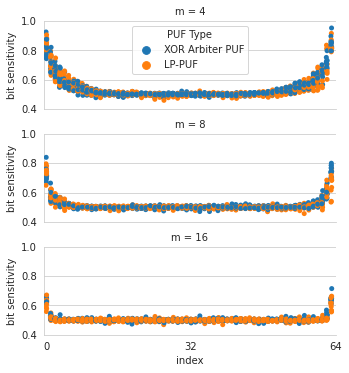

In [10]:
melted_data['bit sensitivity'] = melted_data['bit_sensitivity']
melted_data['PUF Type'] = melted_data['puf_type']

g = sns.catplot(
    x='index', 
    y='bit sensitivity', 
    row='m', 
    hue='PUF Type', 
    data=melted_data[melted_data['m']>2],
    #kind='box',
    aspect=3.2/1,
    height=1.7,
    sharey=False,
    legend_out=False,
)
g.set(xticks=[0, 32, 64], xticklabels=[0, 32, 64], ylim=(.4, 1))

In [11]:
g.fig.tight_layout(pad=0)
g.savefig('figures/bit-sensitivity.pdf')